# Importação do csv + lowercasing

Base contendo 154 categorias com 30 instâncias cada. Registros nulos e duplicados foram removidos.


In [6]:
import pandas as pd

df = pd.read_csv('data/produtos_categorias.csv', delimiter=";") # csv to dataframe
df = df.applymap(str.lower) #lowercase

df.columns = ['produto', 'categoria'] # lowercase titles

#print(df.head())

                                    produto    categoria
0   '.always protecao total/normal (todos)'  absorventes
1                 '.always basico (outros)'  absorventes
2                  '.a hig_.intimus(todos)'  absorventes
3            '.a hig_.sempre livre (todos)'  absorventes
4  'sempre livre slinea s/seca c/abas c/10'  absorventes


# Pré-processamento

In [33]:
df['produto'] = df['produto'].str.replace('[^a-zA-Z0-9]', ' ') # Permite apenas letras e números
df['produto'] = df['produto'].str.findall('\w{3,}').str.join(' ') # Mantém apenas palavras com 3+ letras
#df['PRODUTO'] = df['PRODUTO'].str.replace('\d+', '') # remove only numbers
#df["PRODUTO"] = df['PRODUTO'].str.replace('[^\w\s]','') # remove simbols except _
#df["PRODUTO"] = df['PRODUTO'].str.replace('[^a-zA-Z]',' ') # let only letters

# Adiciona categoria como inteiro na coluna categoria_id
df['categoria_id'] = df['categoria'].factorize()[0] 

# Cria dicionário de categorias para uso na matriz de confusão
categoria_id_df = df[['categoria', 'categoria_id']].drop_duplicates().sort_values('categoria_id')


# Exibe gráfico de distribuição por categoria

#import matplotlib.pyplot as plt

#fig = plt.figure(figsize=(8,6))
#df.groupby('categoria').produto.count().plot.bar(ylim=0)


                                      categoria  categoria_id
0                                   absorventes             0
30                                       acucar             1
60                               'agua de coco'             2
90                               'agua mineral'             3
120                            'agua sanitaria'             4
150                        'aguardente de cana'             5
180                                      alcool             6
210                          'alimento p/ caes'             7
240                         'alimento p/ gatos'             8
270             'antissepticos bucais liquidos'             9
300                   'antissepticos para maos'            10
330                          'aparelho celular'            11
360                                  aperitivos            12
390                                       arroz            13
420                           'artigos de mesa'            14
450     

# TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 5))

features = tfidf.fit_transform(df.produto).toarray()
labels = df.categoria_id
features.shape


(4620, 1551)

# Comparação entre os modelos

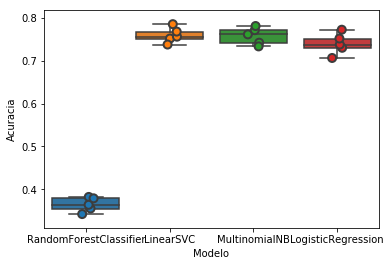

Modelo
LinearSVC                 0.760173
LogisticRegression        0.740043
MultinomialNB             0.758225
RandomForestClassifier    0.364286
Name: Acuracia, dtype: float64

In [29]:
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Validação
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Gráfico de comparação
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto'),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Modelo', 'fold_idx', 'Acuracia'])

sns.boxplot(x='Modelo', y='Acuracia', data=cv_df)
sns.stripplot(x='Modelo', y='Acuracia', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('Modelo').Acuracia.mean()

# Matriz de confusão

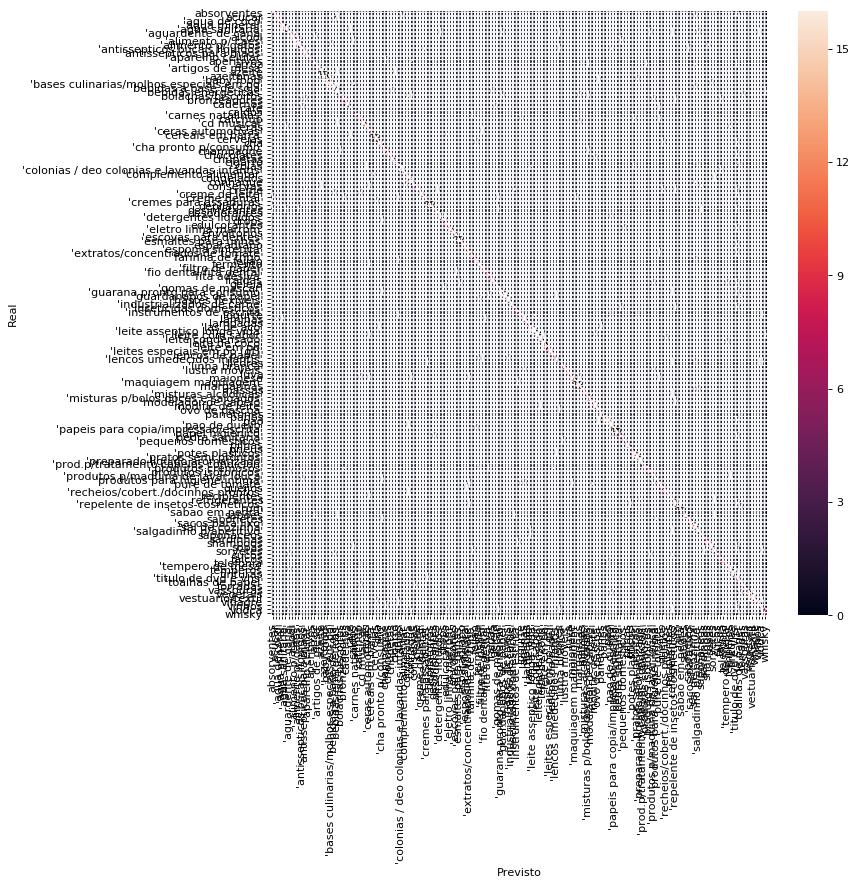

In [34]:
from sklearn.model_selection import train_test_split

model = LinearSVC() # Modelo a ser exibido na matriz 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categoria_id_df.categoria.values, yticklabels=categoria_id_df.categoria.values)

plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()